In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
#from geopy.distance import geodesic # too expensive computationally for the amount of data at hand
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
import pickle
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from time import time

### Functions:

In [ ]:
#add new features to df:
def add_newFeats(df):
    
    #compute distance function (distance in km)
    def haversine_distance(df_pickup_lat, df_pickup_long,df_dropoff_lat,df_dropoff_long):

    #6367 earth radius
        distance_col = 6367 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(df_pickup_lat) /
                                                - np.radians(df_dropoff_lat))/2)**2 /
                                                + np.cos(np.radians(df_dropoff_lat))*np.cos(np.radians(df_pickup_lat))*np.sin((np.radians(df_pickup_long) - np.radians(df_dropoff_long))/2)**2))
        return distance_col
    
    
    #add features related with datetime
    df['key'] = pd.to_datetime(df['key'])
    df['weekday'] = df['key'].dt.dayofweek
    df['year']=df['key'].dt.year
    df['month']=df['key'].dt.month
    df['day']=df['key'].dt.day
    df['hour']=df['key'].dt.hour

    #Absolute differences between longitudes and between latitudes
    df ['abs_diff_longitude']=np.abs(df.pickup_longitude-df.dropoff_longitude)
    df ['abs_diff_latitude']=np.abs(df.pickup_latitude-df.dropoff_latitude)
    
    #there are some flat rates on trips from/to some of the airports in NY (JFK, LaGuardia, Newark) so we add features of
    #distances from/to these airports
    # coordinates from https://get-direction.com
    jfk_latitude = 40.644538879
    jfk_longitude = -73.795356750
    laguardia_latitude = 40.774009705
    laguardia_longitude =-73.872497559
    newark_latitude = 40.692878723
    newark_longitude = -74.185447693 
        
    #distances: between pickup and dropoffs, and distances to the main 3 airports in NYC
    #note: Newark is actually New Jersey, that's also why the bounding box was also larger
    df['distance'] = haversine_distance(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])
    df['pickup_distance_jfk'] = haversine_distance(df['pickup_latitude'],df['pickup_longitude'],jfk_latitude, jfk_longitude)
    df['pickup_distance_laguardia'] = haversine_distance(df['pickup_latitude'],df['pickup_longitude'],laguardia_latitude, laguardia_longitude)
    df['pickup_distance_newark'] = haversine_distance(df['pickup_latitude'],df['pickup_longitude'],newark_latitude, newark_longitude)
    df['dropoff_distance_jfk'] = haversine_distance(df['dropoff_latitude'],df['dropoff_longitude'],jfk_latitude, jfk_longitude)
    df['dropoff_distance_newark'] = haversine_distance(df['dropoff_latitude'],df['dropoff_longitude'],newark_latitude, newark_longitude)

    df['dropoff_distance_laguardia'] = haversine_distance(df['dropoff_latitude'],df['dropoff_longitude'],laguardia_latitude, laguardia_longitude)
    
    #log transform for distance feats
    df['distance_log'] = df['distance'].transform(lambda x: np.log(x+sys.float_info.epsilon))
    df['abs_diff_latitude_log'] = df['abs_diff_latitude'].transform(lambda x: np.log(x+sys.float_info.epsilon))
    df['abs_diff_longitude_log'] = df['abs_diff_longitude'].transform(lambda x: np.log(x+sys.float_info.epsilon))
    
    return df


## Read training data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#train_path = '/content/drive/My Drive/Colab Notebooks/train_orig.csv'
train_path = 'train_orig.csv'

In [4]:
train = pd.read_csv(train_path, nrows=1_000_000) #only a portion of observations are selected, 
                                                #since it is a big dataset
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


## Pre-processing of data + exploratory analysis

### Drop basic outliers 

Training data set is large, so it can be afforded to drop all errouneous observations (rather than imputing them)

In [7]:
#drop duplicates
train.drop_duplicates(keep = 'first', inplace = True)
train.shape[0] #no duplicates found

1000000

In [8]:
#check if there are some NaN values
train.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [9]:
#drop NaN values
train.dropna(inplace=True)

In [10]:
#limit the coordinates to proper ranges, to compute distances

#Latitudes range from -90 to 90. Longitudes range from -180 to 180.
train = train[ (train.pickup_longitude >= -180) & (train.pickup_longitude <= 180) & \
              (train.dropoff_longitude >= -180) & (train.dropoff_longitude <= 180) & \
              (train.pickup_latitude >= -90) & (train.pickup_latitude <= 90) & \
              (train.dropoff_latitude >= -90) & (train.dropoff_latitude <= 90) ]

train.shape[0]

999950

### Drop other outliers 

In [11]:
#based on these descriptors, another outliers can be removed:
#1) new york city actually has the following bounding box of coordinates (https://boundingbox.klokantech.com/)
    #eastlimit_longitude=-73.700181
    #southlimit_latitude =40.47739894
    #westlimit_longitude=-74.25909
    #northlimit_latitude=40.916178

#here it is used a bounding box slightly larger than the actual NY, so there is more flexibility for trips 
#around airport (specially Newark airport, that is New Jersey actually)
eastlimit_longitude=-73.664465
southlimit_latitude=40.477399
westlimit_longitude=-74.307165
northlimit_latitude=40.935154

train = train[ (train.pickup_longitude >= westlimit_longitude) & (train.pickup_longitude <= eastlimit_longitude) & \
              (train.dropoff_longitude >= westlimit_longitude) & (train.dropoff_longitude <= eastlimit_longitude) & \
              (train.pickup_latitude >= southlimit_latitude ) & (train.pickup_latitude <= northlimit_latitude) & \
              (train.dropoff_latitude >= southlimit_latitude) & (train.dropoff_latitude <= northlimit_latitude) ]

train.shape[0]

978105

We can see that while the bounding box was slightly larger than the actual NYC border, still quite a few points were outside of this boundary. The data set is still though quite large. Thus, it is decided to drop these values.

Other observations are then dropped, based on fare amount and passenger count.

In [12]:
#2) passengers in a taxi, up to 6 (icnluding SUVs) https://ride.guru/lounge/p/how-many-people-can-ride-in-a-cab 
    #0-passenger-cases are kept, in case documents are transported
#3) fare has to be positive value, over or equal to 2.50$ (that seems to be the initial charge)
    #https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
                                                                                                               
train = train[(train.passenger_count<= 6) & \
              (train.fare_amount > 2.50)  ]

train.shape[0]

974575

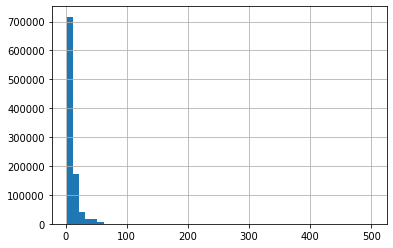

In [13]:
train.fare_amount.hist(bins=50)

Variable 'fare_mount' now seems too high in value (500), with a very high variance. Thus, the maximum 'fare_amount' value is limited.

In [14]:
#limit fare_amount based on histogram
train = train[ (train.fare_amount < 100)]
train.shape[0]

974388

### Adding features

Note that preprocessing and exploratory analysis are steps that feed each other. Thus, some of the pre-processing done here (adding features) has been done based on visualizations from the following step.

In [15]:
train = add_newFeats(train)

In [16]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,...,distance,pickup_distance_jfk,pickup_distance_laguardia,pickup_distance_newark,dropoff_distance_jfk,dropoff_distance_newark,dropoff_distance_laguardia,distance_log,abs_diff_latitude_log,abs_diff_longitude_log
count,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,...,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000
mean,11.302589,-73.975547,40.750897,-73.974596,40.751250,1.686087,3.039591,2011.740771,6.269020,15.691382,...,1.206739,9.633673,5.648909,11.192924,9.579942,11.243857,5.562777,-0.826884,-4.673671,-4.763274
std,9.309636,0.034337,0.026812,0.033876,0.030721,1.308440,1.949780,1.862689,3.438059,8.683095,...,1.779557,1.731019,1.244893,1.826411,1.721616,1.802738,1.368310,3.729288,3.340048,3.362732
min,2.510000,-74.299640,40.481047,-74.300537,40.479537,0.000000,0.000000,2009.000000,1.000000,1.000000,...,0.000000,0.001585,0.000077,0.006963,0.000280,0.009872,0.000023,-36.043653,-36.043653,-36.043653
25%,6.000000,-73.992279,40.736600,-73.991573,40.735617,1.000000,1.000000,2010.000000,3.000000,8.000000,...,0.329575,9.235921,5.110038,10.298683,9.077374,10.336614,4.965867,-1.109951,-4.962560,-5.085467
50%,8.500000,-73.982097,40.753415,-73.980610,40.753873,1.000000,3.000000,2012.000000,6.000000,16.000000,...,0.678752,9.966250,5.838177,10.845001,9.885530,10.923105,5.760235,-0.387499,-4.253809,-4.363009
75%,12.500000,-73.968400,40.767557,-73.965427,40.768405,2.000000,5.000000,2013.000000,9.000000,23.000000,...,1.275547,10.506294,6.378518,11.576394,10.469044,11.734702,6.342576,0.243375,-3.604097,-3.732121
max,99.750000,-73.665171,40.932743,-73.664619,40.935133,6.000000,6.000000,2015.000000,12.000000,31.000000,...,27.452157,26.815742,22.669672,27.795514,26.863091,27.781329,22.716982,3.312445,-1.161728,-0.662666


Now there is some outlier removal again based on these new features.

Regarding the observations of distances with 0 value: at first it was thought to keep those observations for which distance is 0 while fare_amount is larger than 0 (and in addition pickup and dropoff coordinates are the same). These observations could be thought of coming from waiting times of the taxi (when it arrives to place and waits for the customer, but the customer doesn't show up). These observations would show the relation between fare_amount and time variable (not present in the set), regardless of distance, and therefore could add to the modeling. However, keeping these kind of observations proved to be more detrimental for the model than benefitial, so they were droped.

In [17]:
#removed any row with distance equal to 0:
train = train[ (train.distance > 0)]

In [18]:
train.isna().sum()

key                           0
fare_amount                   0
pickup_datetime               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
passenger_count               0
weekday                       0
year                          0
month                         0
day                           0
hour                          0
abs_diff_longitude            0
abs_diff_latitude             0
distance                      0
pickup_distance_jfk           0
pickup_distance_laguardia     0
pickup_distance_newark        0
dropoff_distance_jfk          0
dropoff_distance_newark       0
dropoff_distance_laguardia    0
distance_log                  0
abs_diff_latitude_log         0
abs_diff_longitude_log        0
dtype: int64

In [19]:
#train.dropna(inplace=True)
train.shape[0]

964806

### Exploratory analysis (with data visualizations)

Looking at the features distribution show that 'distance' and 'abs_diff_latitude' and 'abs_diff_longitude' features show an exponential distribution (as well as 'fare_amount' dependent variable). Since at first we were using a linear regression model, these features were log-transformed and added to the available features, since they may work better with that kind of model.

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea83adf518>,
      dtype=object)

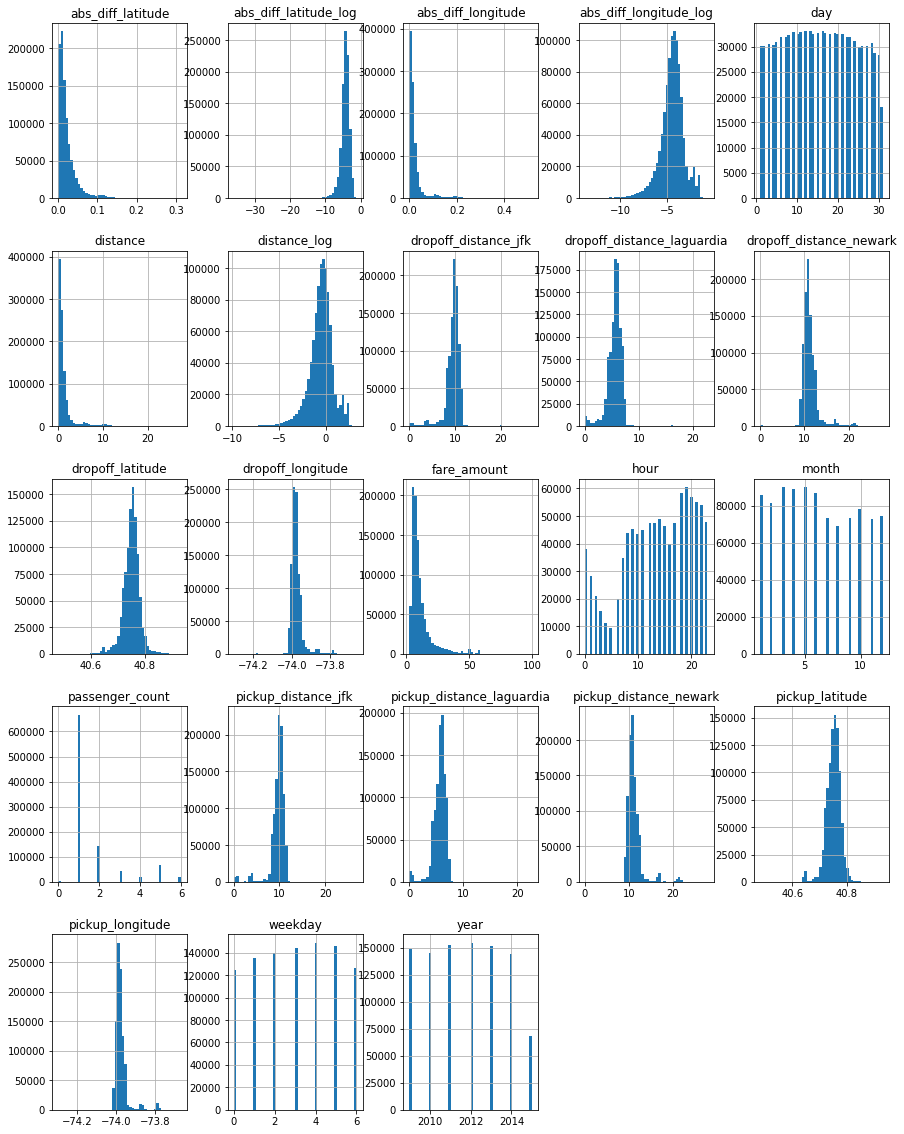

In [20]:
#check distributions of all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=50)

Next, a <b>correlation analysis</b> was done to check linear dependencies:

In [21]:
corr_pearson = train.corr(method='pearson')
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

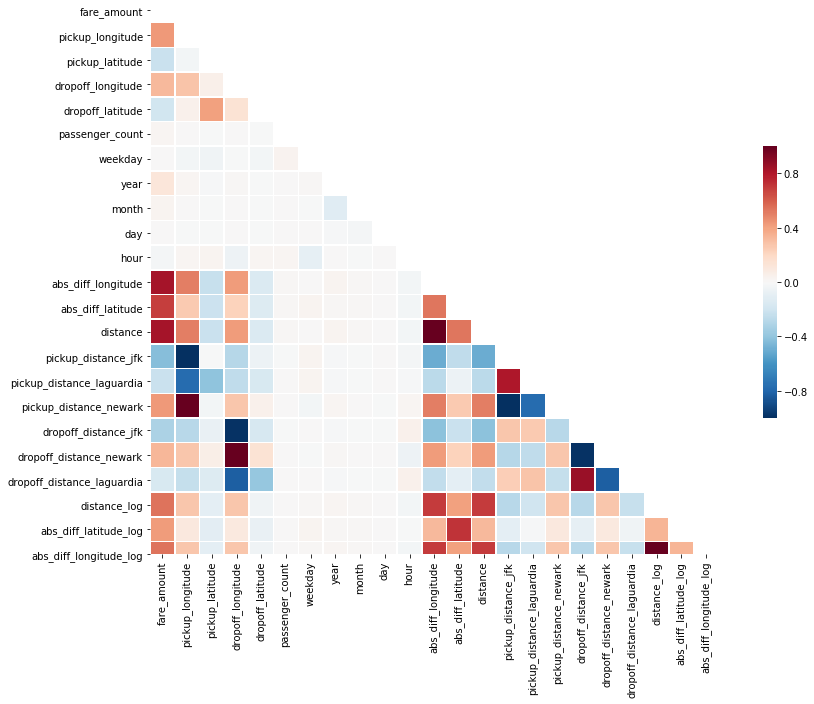

In [22]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pearson, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1)

If we focus on the column of correlations between 'fare_amount' and the independent variables (first column), we can see that the features that show more correlation with 'fare_amount' are the distance features, and also the abs_diff features. The one that shows the most correlation is 'distance'.

We look also at non-linear dependencies with a <b>mutual information (MI) analysis</b>:

In [23]:
#mutual information has too expensive computationally to run for all data, so we just take a portion
#in addition MI scores are done in two sets of features, for memory reasons
feats_MI1 = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',\
                'passenger_count', 'weekday', 'year', 'month', 'day', 'hour', 'abs_diff_longitude',\
                'abs_diff_latitude']

Xarray1 = train[feats_MI1].to_numpy()[1:50000,:]
Yarray = train.fare_amount.to_numpy()[1:50000]

feature_MIscores1 = sklearn.feature_selection.mutual_info_regression(Xarray1, Yarray)

In [24]:
feats_MI2 = ['distance','pickup_distance_jfk', 'pickup_distance_laguardia','pickup_distance_newark',\
                 'dropoff_distance_jfk','dropoff_distance_newark', 'dropoff_distance_laguardia', 'distance_log',\
                 'abs_diff_latitude_log', 'abs_diff_longitude_log']

Xarray2 = train[feats_MI2].to_numpy()[1:50000,:]
feature_MIscores2 = sklearn.feature_selection.mutual_info_regression(Xarray2, Yarray)

([<matplotlib.axis.YTick at 0x7fea604642b0>,
 <a list of 12 Text yticklabel objects>)

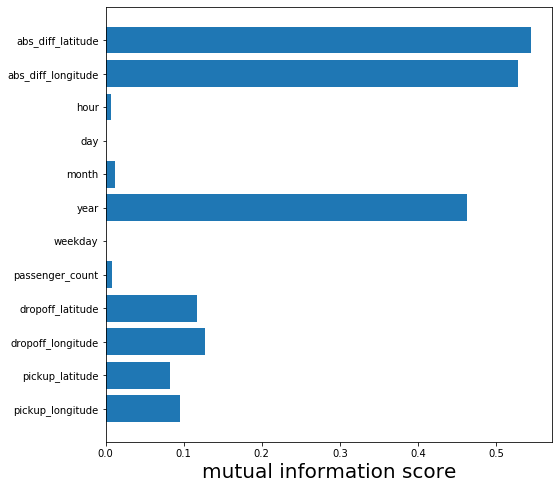

In [58]:
index_MI1 = np.arange(len(feats_MI1))
plt.figure(figsize=(8,8))
plt.barh(index_MI1, feature_MIscores1)
plt.xlabel('mutual information score', fontsize=20)
plt.yticks(index_MI1,feats_MI1, fontsize=10, rotation=0)

([<matplotlib.axis.YTick at 0x7fea6036d6d8>,
 <a list of 10 Text yticklabel objects>)

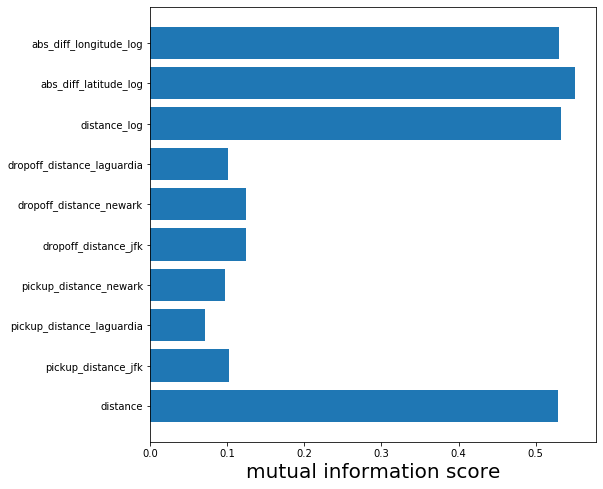

In [60]:
index_MI2 = np.arange(len(feats_MI2))
plt.figure(figsize=(8,8))
plt.barh(index_MI2, feature_MIscores2)
plt.xlabel('mutual information score', fontsize=20)
plt.yticks(index_MI2, feats_MI2, fontsize=10, rotation=0)

Mutual information analysis show similar results as in correlation analysis. Nevertheless, 'year' feature for example seems to add more information to what correlation shows (thus, it adds more in terms of non-linearity).

Given 'distance' is the feature that shows a stronger relationship to 'fare_amount', we analyze first in a scatter plot the relationship of these two variables:

The large amount of data points visualize clatter the visualization. Thus, a hex binnins is done, that shows more clearly the distance-fare_amount relation:

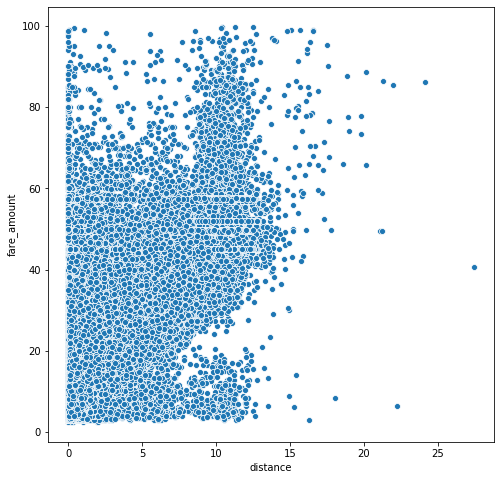

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.scatterplot(ax=ax,x="distance", y="fare_amount", data=train)

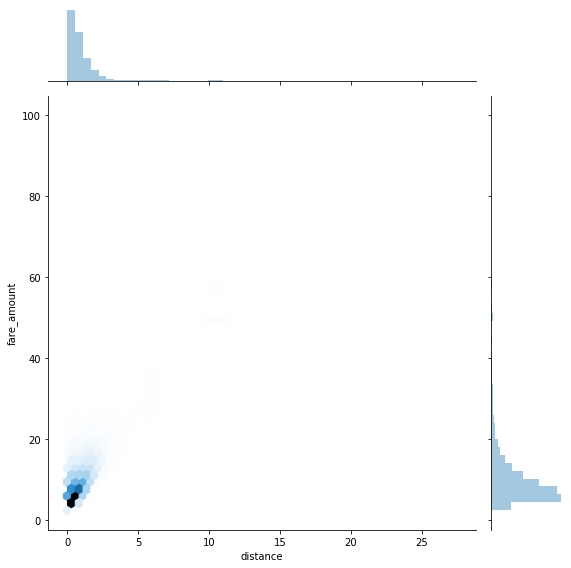

In [62]:
sns.jointplot(x="distance", y="fare_amount", data=train, kind='hex',height=8)

Based on this plot, there seems to be a linear relationship between the two features. 
A similar line occurs if we do  linear regression between the two variables:

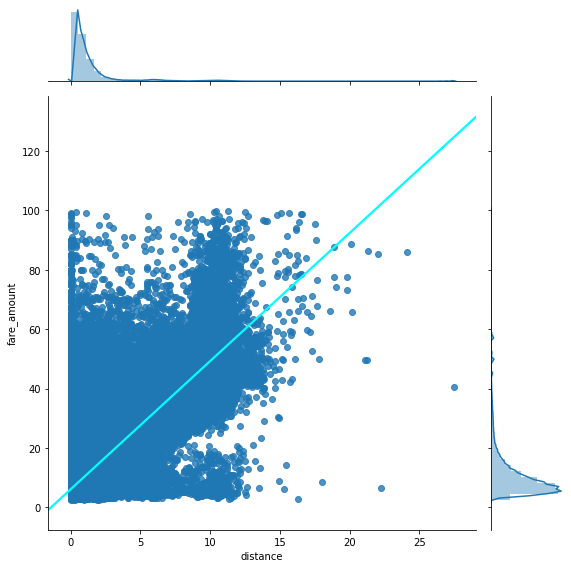

In [63]:
sns.jointplot(x="distance", y="fare_amount", data=train, kind='reg',joint_kws={'line_kws':{'color':'cyan'}},height=8)

We also plot distance in log-domain ('distance_log') against 'fare_amount' to check their relationship, since it may be easier to see in that case (the distance scale is shrunk).

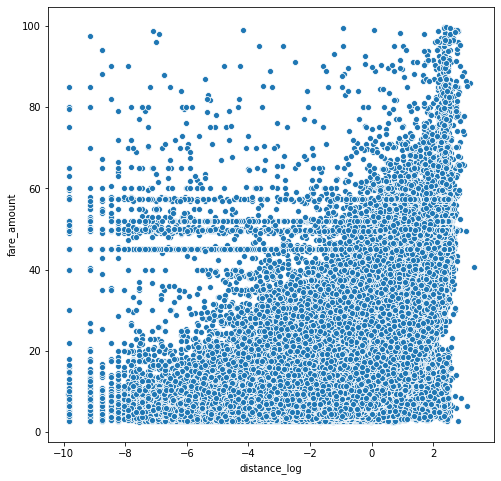

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.scatterplot(ax=ax,x="distance_log", y="fare_amount", data=train)

From this figure we see that there is several lines between 40$ and 60$, which indicates a flat rate of some sort. Googling this, one finds that there is flat rates to/from airports:

* Taxis between JFK airport and Manhattan have a flat rate of 52$ and there is a surchage of $4.50 in peak hours (4-8 p.m. weekdays, excluding holidays.) Source: https://www.jfkairport.com/to-from-airport/taxi-car-and-van-service

* In case of Newark airport, the flat rate seems more ambiguous: "Taxis also operate from the airport at flat rates based on destination.". In addition, "During weekday rush hours there is a fee charge of USD $5.00." Source: https://www.airport-ewr.com/taxi.php

* In case of LaGuardia, there is a flat rate of 15$ to the city center. However, this is difficult to see in the figure, given that at that fare rate range there are much more observations. Source: https://www.cntraveler.com/story/laguardia-airport-now-has-dollar15-flat-rate-rides-to-manhattan-and-brooklyn

Based on this, it was decided to add some features that would indicate if the trip is to a specific airport: distance between pickup (or dropoff) location and airport was used in the end.

Then again we use hex bins, because in the regular scatter plot the data points are cluttered together.

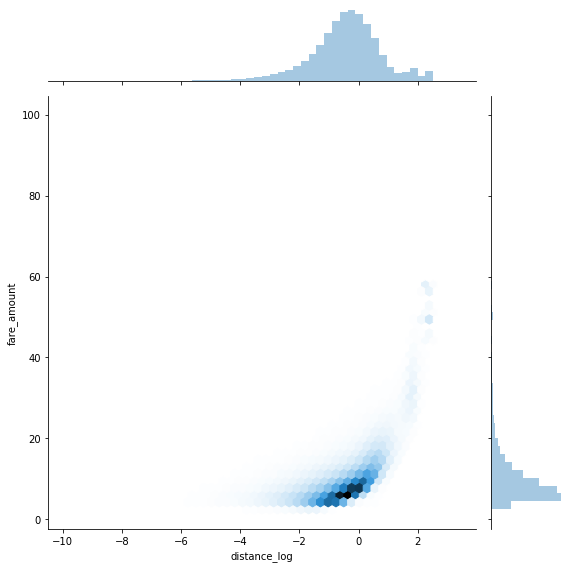

In [65]:
sns.jointplot(x="distance_log", y="fare_amount", data=train, kind='hex',height=8)

The clear relation between distance and fare amount is more clear here. The plot also shows how the flat rate trips (airport trips probably) are not so common in the observed data set.

In the following graphic, we show the mean ( and standard deviation error bars) of 'fare_amount' per hour, along the histogram of hours observed.

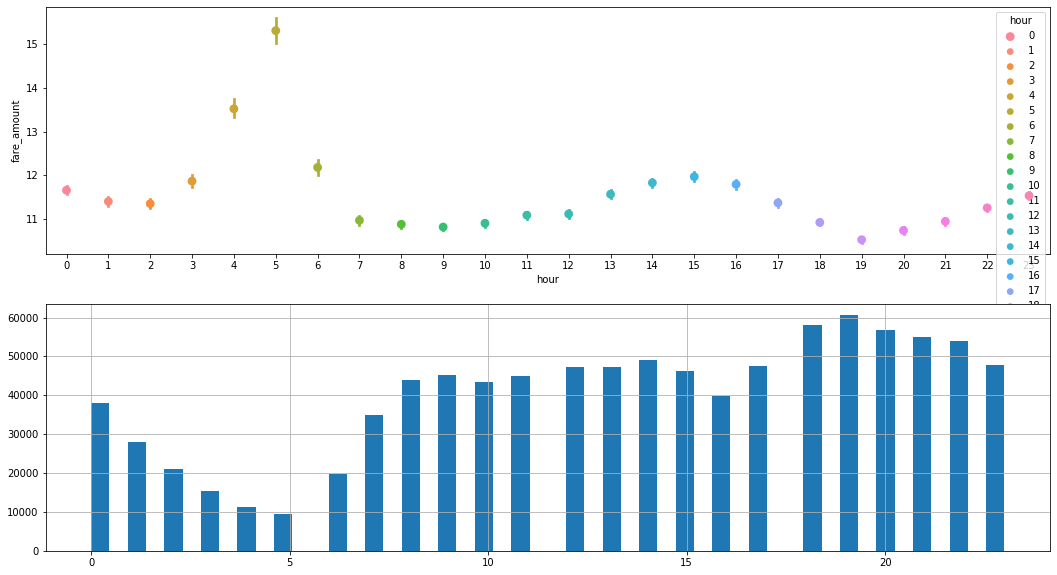

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
sns.pointplot(ax=axes.flatten()[0], y='fare_amount', x='hour', hue='hour', data=train, dodge=False, join=True)
train['hour'].hist(ax=axes.flatten()[1], bins=50)

A similar analysis is done, per day of the week:

[Text(0, 0, 'days'),
 Text(0, 0, 'Mon'),
 Text(0, 0, 'Tue'),
 Text(0, 0, 'Wed'),
 Text(0, 0, 'Thu'),
 Text(0, 0, 'Fri'),
 Text(0, 0, 'Sat'),
 Text(0, 0, 'Sun')]

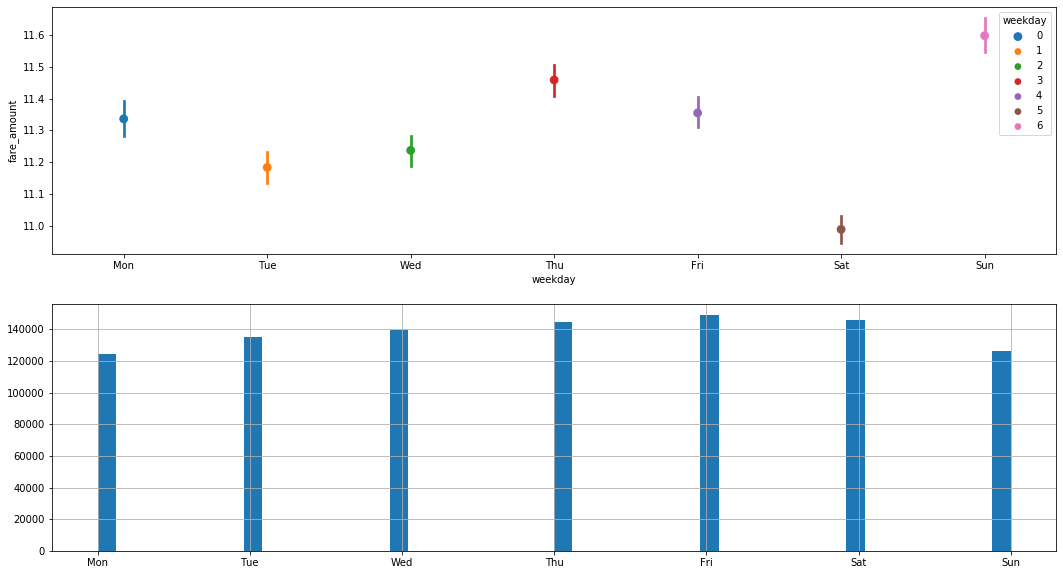

In [56]:
days= ['days','Mon','Tue','Wed','Thu','Fri','Sat','Sun']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
g1=sns.pointplot(ax=axes.flatten()[0], y='fare_amount', x='weekday', hue='weekday', data=train, dodge=False, join=True)
g1.set_xticklabels(days[1:]) 
g2 = train['weekday'].hist(ax=axes.flatten()[1], bins=50)
g2.set_xticklabels(days)

And the same per month:

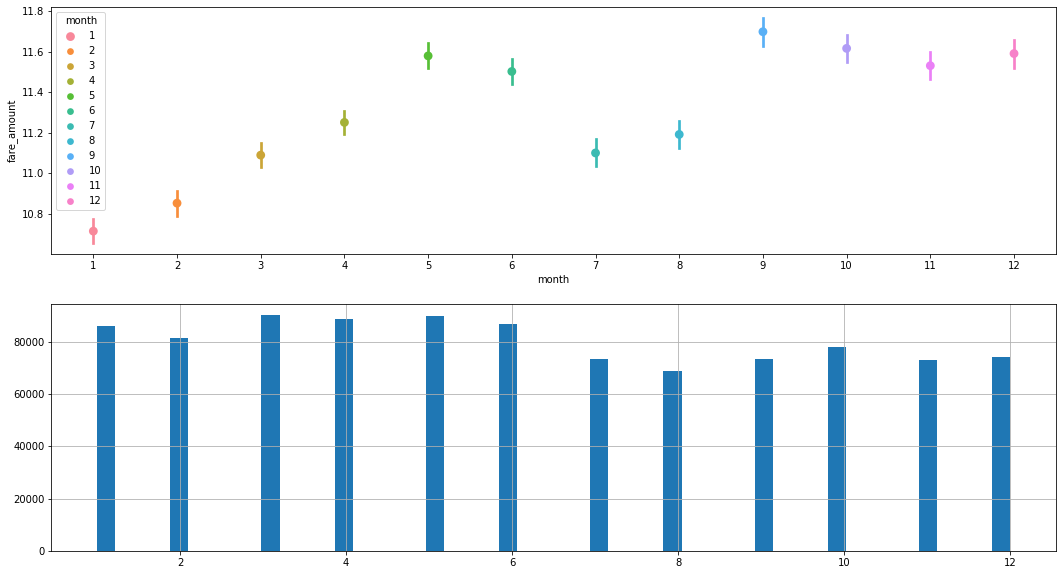

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
sns.pointplot(ax=axes.flatten()[0], y='fare_amount', x='month', hue='month', data=train, dodge=False, join=True)
train['month'].hist(ax=axes.flatten()[1], bins=50)

Now we analyze 'fare_amount' by 'year' (and 'distance'). We see here a clear increase, specially from 2012 onwards there seems a clear line. According to news, it seems that around September 2012 the taxi fare prices rised around a 17%. Source: https://www.businessinsider.com/taxis-in-nyc-just-got-more-expensive-2012-9?r=US&IR=T

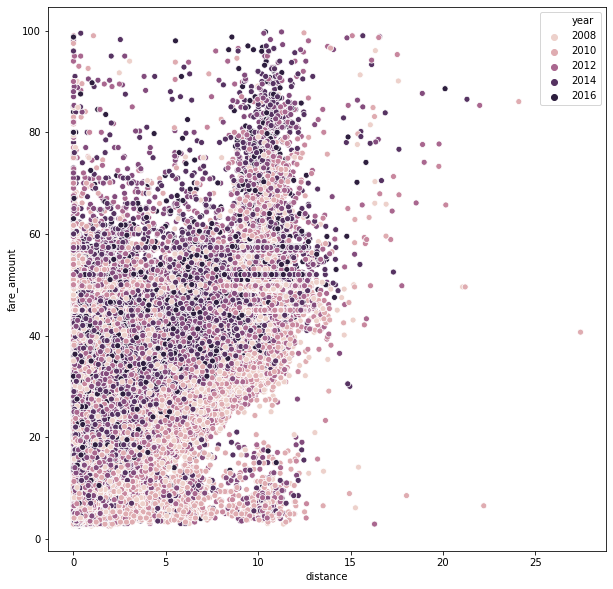

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
sns.scatterplot(x="distance", y="fare_amount", data=train, hue='year',ax=ax)

## Preparing data for modeling (train + validation data sets)

In [69]:
train2, val = train_test_split(train, test_size=0.3)

We now select the features used for modeling the regression process. At the end only set of features dropped are the log-distance-related features since they do not seem to help in linear models (in which the features are 
assumed to be normally-distributed). The other features were selected, even though seem to carry small information (like passenger count). Thus, future work may be done on feature selection to try to improve the results.

In [72]:
#dropping the log-distances features, 
feature_set = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', \
                'passenger_count', 'weekday', 'year', 'month', 'day', 'hour', 'abs_diff_longitude', \
                'abs_diff_latitude', 'distance', 'pickup_distance_jfk', 'pickup_distance_laguardia', \
                'pickup_distance_newark', 'dropoff_distance_jfk', 'dropoff_distance_newark', \
                'dropoff_distance_laguardia' ]

In [74]:
X_train = train2[feature_set]
y_train = train2[['fare_amount']]

X_val = val[feature_set]
y_val = val[['fare_amount']]

Standardization of the data sets is done for the case of linear regression and linear regression with Lasso regularization. The models based on decision trees do not require it.

In [75]:
scaler = StandardScaler()
scaler.fit(X_train)

#use same scaler for both, based on X_train data
X_trainNorm = scaler.transform(X_train)
X_valNorm = scaler.transform(X_val)

## Regression modeling 

Comparison of several regression models, plus a dummy model as baseline.

In evaluation two metrics are used: 

* R2 is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).
* Mean squared error (MSE) --> This is the main metric we care about.

In addition, the models' training times are computed.

### Dummy model

#### Training:

In [76]:
dummy_regr = DummyRegressor(strategy="mean")
t0_dummy=time()
dummy_regr.fit(X_train, y_train)
print(dummy_regr)
print("Dummy model 'regression', training time:" + str(round(time()-t0_dummy, 3)) + "s")

DummyRegressor(constant=None, quantile=None, strategy='mean')
Dummy model 'regression', training time:0.005s


#### Prediction:

In [77]:
y_valPred_dummy = dummy_regr.predict(X_val)
y_trainPred_dummy = dummy_regr.predict(X_train)

#### Evaluation:

In [78]:


r2_val_dummy = r2_score(y_val, y_valPred_dummy)
r2_train_dummy = r2_score(y_train, y_trainPred_dummy)

print('Dummy model- training, R2:' + str(r2_train_dummy))
print('Dummy model- validation, R2:' + str(r2_val_dummy))


Dummy model- training, R2:0.0
Dummy model- validation, R2:-1.0106197972259423e-05


In [79]:
mse_val_dummy = mean_squared_error(y_val, y_valPred_dummy)
mse_train_dummy = mean_squared_error(y_train, y_trainPred_dummy)

print('Dummy model - training, MSE:' + str(mse_train_dummy))
print('Dummy model - validation, MSE:' + str(mse_val_dummy))

Dummy model - training, MSE:85.67373114572152
Dummy model - validation, MSE:86.9073414451721


### Linear regression

#### Training:

In [80]:
linRegr = linear_model.LinearRegression()
t0_linR=time()
linRegr.fit(X_trainNorm, y_train)
print(linRegr)
print("Linear regression, training time:" + str(round(time()-t0_linR, 3)) + "s")

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Linear regression, training time:0.507s


#### Prediction:

In [81]:
y_valPred_linReg = linRegr.predict(X_valNorm) #to check validation error measures
y_trainPred_linReg = linRegr.predict(X_trainNorm) #to check training error measures

#### Evaluation:

In [82]:
r2_val_linReg = r2_score(y_val, y_valPred_linReg)
r2_train_linReg = r2_score(y_train, y_trainPred_linReg)

print('Linear regression - training, R2:' + str(r2_train_linReg))
print('Linear regression - validation, R2:' + str(r2_val_linReg))


Linear regression - training, R2:0.7943673345048179
Linear regression - validation, R2:0.7919745355845684


In [83]:
mse_val_linReg = mean_squared_error(y_val, y_valPred_linReg)
mse_train_linReg = mean_squared_error(y_train, y_trainPred_linReg)

print('Linear regression - training, MSE:' + str(mse_train_linReg))
print('Linear regression - validation, MSE:' + str(mse_val_linReg))


Linear regression - training, MSE:17.617317698412318
Linear regression - validation, MSE:18.078757357741463


Text(0.5, 1.0, 'Linear regression - Feature weights')

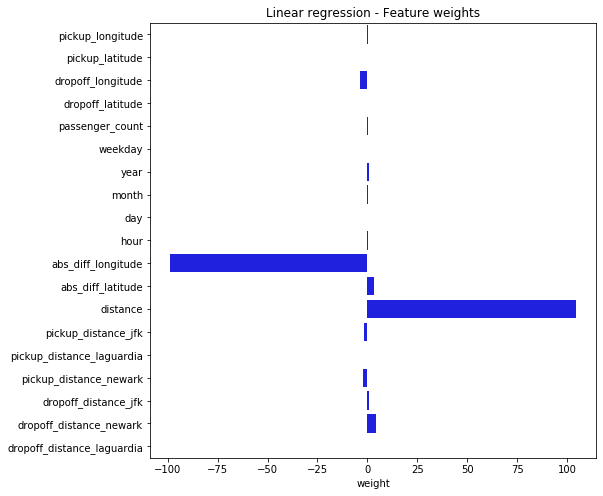

In [128]:
coeffcs_linR = pd.DataFrame(linRegr.coef_.transpose(), index=X_train.columns, columns=["weight"])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.barplot(ax=ax,x='weight', y=coeffcs_linR.index, data=coeffcs_linR, color='blue')\
.set_title('Linear regression - Feature weights')

### Linear regression with Lasso regularization (i.e. feature selection)

#### Training:

In [93]:
lassoReg = linear_model.LassoCV(cv=10)
t0_linRLasso=time()
lassoReg.fit(X_trainNorm, y_train.values.ravel())
print(lassoReg)
print("Linear regression with Lasso reg., training time:" + str(round(time()-t0_linRLasso, 3)) + "s")

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)
Linear regression with Lasso reg., training time:16.998s


#### Prediction:

In [94]:
y_valPred_lassoReg = lassoReg.predict(X_valNorm)
y_trainPred_lassoReg = lassoReg.predict(X_trainNorm)

#### Evaluation:

In [95]:
r2_val_lassoReg = r2_score(y_val, y_valPred_lassoReg)
r2_train_lassoReg = r2_score(y_train, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, R2:' + str(r2_train_lassoReg))
print('Linear regression with Lasso reg. - validation, R2:' + str(r2_val_lassoReg))

Linear regression with Lasso reg. - training, R2:0.7941258211943432
Linear regression with Lasso reg. - validation, R2:0.7919299840789045


In [96]:
mse_val_lassoReg = mean_squared_error(y_val, y_valPred_lassoReg)
mse_train_lassoReg = mean_squared_error(y_train, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, MSE:' + str(mse_train_lassoReg))
print('Linear regression with Lasso reg. - validation, MSE:' + str(mse_val_lassoReg))

Linear regression with Lasso reg. - training, MSE:17.638009044842047
Linear regression with Lasso reg. - validation, MSE:18.082629171526772


Text(0.5, 1.0, 'Linear regression, with Lasso reg. - Feature weights')

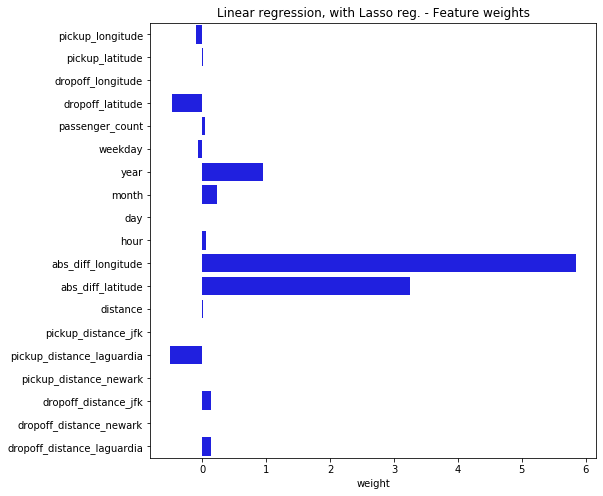

In [127]:
coeffcs_lasso = pd.DataFrame(lassoReg.coef_, index=X_train.columns, columns=["weight"])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.barplot(ax=ax,x='weight', y=coeffcs_lasso.index, data=coeffcs_lasso, color='blue')\
.set_title('Linear regression, with Lasso reg. - Feature weights')

### Random forest regression

Decision trees can deal with non-linearity relationships between independent variables and the dependent variable (fare_amount), unlike linear regressors.

#### Training:

In [98]:
randFor = RandomForestRegressor(n_estimators=10) #current default, future is 100, but it is too much computation

#decisions trees don't need normalized data since they don't assume any distribution

t0_randFor=time()
randFor.fit(X_train, y_train.values.ravel())
print(randFor)
print("Random forest regression, training time:" + str(round(time()-t0_randFor, 3)) + "s")

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Random forest regression, training time:179.326s


#### Prediction:

In [99]:
y_valPred_randFor = randFor.predict(X_val)
y_trainPred_randFor = randFor.predict(X_train)

#### Evaluation:

In [100]:
r2_val_randFor = r2_score(y_val, y_valPred_randFor)
r2_train_randFor = r2_score(y_train, y_trainPred_randFor)

print('Random forest regression - training, R2:' + str(r2_train_randFor))
print('Random forest regression - validation, R2:' + str(r2_val_randFor))

Random forest regression - training, R2:0.9769200307650372
Random forest regression - validation, R2:0.871943414335635


In [101]:
mse_val_randFor = mean_squared_error(y_val, y_valPred_randFor)
mse_train_randFor = mean_squared_error(y_train, y_trainPred_randFor)

print('Random forest regression - training, MSE:' + str(mse_train_randFor))
print('Random forest regression - validation, MSE:' + str(mse_val_randFor))

Random forest regression - training, MSE:1.9773470790877226
Random forest regression - validation, MSE:11.128944943315071


Check also the feature importances:

Text(0.5, 1.0, 'Random forest - Feature importances')

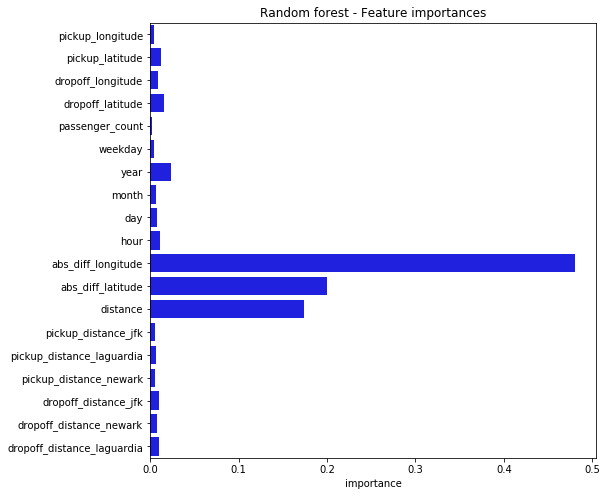

In [126]:
importance_rf = pd.DataFrame(randFor.feature_importances_, index=X_train.columns, columns=["importance"])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.barplot(ax=ax,x='importance', y=importance_rf.index, data=importance_rf, color='blue')\
.set_title('Random forest - Feature importances')
#Avenues generally run north and south in NY. All streets run east and west.
#https://becomeanewyorker.com/streets-and-avenues-there-is-a-differenc/

### XGBoost regression (with parameter tuning)

With this approach we reduce not only variance (as in random forests) but also the bias.
It has also regularization to avoid overfitting.

### Parameter tuning through grid search with cross-validation

In [103]:
# Parameters that are going to be tuned are those given by a multi-element list (max_depth, min_child_weight, and
#learning rate)

params = {
    'max_depth': [3,5,7,9],
    'min_child_weight': [1,3,5],
    'learning_rate': [0.05,0.1,0.3],
    'subsample': [1],
    'colsample_bytree': [1],
    # Other parameters
    'objective': ['reg:squarederror'],
}


#### Find optimal hyper-parameters

In [104]:
#loading saved model
filename_xgbGrid = 'XGBoostGrid_model.sav'
xgbGrid = pickle.load(open(filename_xgbGrid, 'rb'))

In [105]:
best_params = xgbGrid.best_params_
best_params

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1}

#### Training (with tuned hyper-parameters):

In [107]:
tuned_xgbr = xgb.XGBRegressor(max_depth=9,min_child_weight=1,learning_rate= 0.1,objective ='reg:squarederror')
t0_xgbrTune=time()
tuned_xgbr.fit(X_train, y_train.values.ravel())
print(tuned_xgbr)
print("XGBoost regression with tuning, training time:" + str(round(time()-t0_xgbrTune, 3)) + "s")
#saving model
filename_xgbr = 'XGBoostTuned_model.sav'
pickle.dump(tuned_xgbr, open(filename_xgbr, 'wb'))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
XGBoost regression with tuning, training time:329.204s


#### Prediction:

In [108]:
y_valPred_tuned_xgbr = tuned_xgbr.predict(X_val)
y_trainPred_tuned_xgbr = tuned_xgbr.predict(X_train)

#### Evaluation:

In [109]:
r2_val_tuned_xgbr = r2_score(y_val, y_valPred_tuned_xgbr)
r2_train_tuned_xgbr = r2_score(y_train, y_trainPred_tuned_xgbr)

print('XGBoost regression, with tuning - training, R2:' + str(r2_train_tuned_xgbr))
print('XGBoost regression, with tuning - validation, R2:' + str(r2_val_tuned_xgbr))

XGBoost regression, with tuning - training, R2:0.918706990032717
XGBoost regression, with tuning - validation, R2:0.8899337315799384


In [110]:
mse_val_tuned_xgbr = mean_squared_error(y_val, y_valPred_tuned_xgbr)
mse_train_tuned_xgbr = mean_squared_error(y_train, y_trainPred_tuned_xgbr)

print('XGBoost regression - training, MSE:' + str(mse_train_tuned_xgbr))
print('XGBoost forest regression - validation, MSE:' + str(mse_val_tuned_xgbr))

XGBoost regression - training, MSE:6.96467547996346
XGBoost forest regression - validation, MSE:9.565470100643724


Check also the feature importances:

Text(0.5, 1.0, 'XGB - Feature importances')

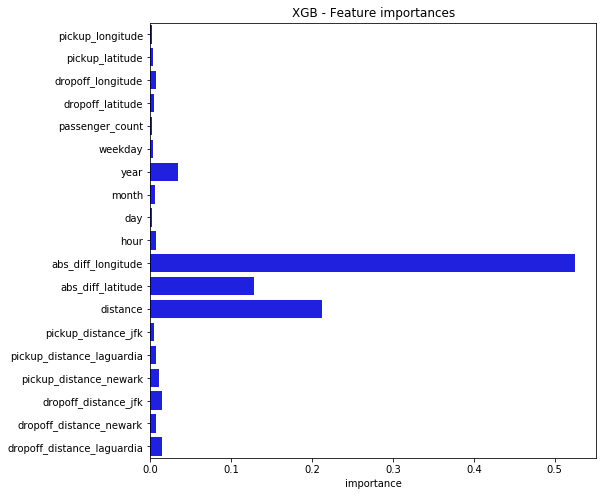

In [125]:
importance_xgbr = pd.DataFrame(tuned_xgbr.feature_importances_, index=X_train.columns, columns=["importance"])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
sns.barplot(ax=ax,x='importance', y=importance_xgbr.index, data=importance_xgbr, color='blue')\
.set_title('XGB - Feature importances')

## Predictions on test set

In [112]:
test_path = 'test_orig.csv'
test = pd.read_csv(test_path)
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [113]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


### Prepare test set before predictions (i.e. add features)

In [114]:
test = add_newFeats(test)

In [115]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,...,distance,pickup_distance_jfk,pickup_distance_laguardia,pickup_distance_newark,dropoff_distance_jfk,dropoff_distance_newark,dropoff_distance_laguardia,distance_log,abs_diff_latitude_log,abs_diff_longitude_log
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,...,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,2.852834,2011.815816,6.857979,16.194170,13.467420,...,1.243933,9.648597,5.685396,11.237838,9.570293,11.294917,5.551162,-0.761367,-4.601563,-4.702361
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.994451,1.803347,3.353272,8.838482,6.868584,...,1.958653,1.933168,1.589563,2.283139,1.812506,2.083768,1.597437,3.531889,3.150416,3.190063
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,...,0.000000,0.009949,0.005357,1.905468,0.041663,0.088896,0.000563,-36.043653,-36.043653,-36.043653
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.000000,2010.000000,4.000000,9.000000,8.000000,...,0.338505,9.220034,5.094757,10.287253,9.010791,10.354199,4.904470,-1.083217,-4.922830,-5.058749
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,3.000000,2012.000000,7.000000,16.000000,15.000000,...,0.699284,9.979375,5.851000,10.833266,9.855911,10.952961,5.731228,-0.357699,-4.218888,-4.333389
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,5.000000,2014.000000,10.000000,25.000000,19.000000,...,1.308633,10.521719,6.393444,11.599358,10.453130,11.808672,6.326527,0.268983,-3.566273,-3.706738
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000,...,45.645175,43.763288,47.844913,64.822849,43.515665,64.571588,47.597004,3.820898,-0.456948,-0.163498


In [116]:
#data is clean of NaNs
test.isna().sum()

key                           0
pickup_datetime               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
passenger_count               0
weekday                       0
year                          0
month                         0
day                           0
hour                          0
abs_diff_longitude            0
abs_diff_latitude             0
distance                      0
pickup_distance_jfk           0
pickup_distance_laguardia     0
pickup_distance_newark        0
dropoff_distance_jfk          0
dropoff_distance_newark       0
dropoff_distance_laguardia    0
distance_log                  0
abs_diff_latitude_log         0
abs_diff_longitude_log        0
dtype: int64

In [117]:
#Check also about the coordinates

test[ (test.pickup_longitude < -180) | (test.pickup_longitude > 180) | \
              (test.dropoff_longitude < -180) | (test.dropoff_longitude > 180) | \
              (test.pickup_latitude < -90) | (test.pickup_latitude > 90) | \
              (test.dropoff_latitude < -90) | (test.dropoff_latitude > 90) ]


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,...,distance,pickup_distance_jfk,pickup_distance_laguardia,pickup_distance_newark,dropoff_distance_jfk,dropoff_distance_newark,dropoff_distance_laguardia,distance_log,abs_diff_latitude_log,abs_diff_longitude_log


In [118]:
sum(test.distance == 0)

86

Select the features for prediction

In [119]:
test_feats = test[feature_set]

In [120]:
test_feats.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,abs_diff_longitude,abs_diff_latitude,distance,pickup_distance_jfk,pickup_distance_laguardia,pickup_distance_newark,dropoff_distance_jfk,dropoff_distance_newark,dropoff_distance_laguardia
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,2.852834,2011.815816,6.857979,16.194170,13.467420,0.023348,0.022133,1.243933,9.648597,5.685396,11.237838,9.570293,11.294917,5.551162
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.994451,1.803347,3.353272,8.838482,6.868584,0.036719,0.025589,1.958653,1.933168,1.589563,2.283139,1.812506,2.083768,1.597437
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.009949,0.005357,1.905468,0.041663,0.088896,0.000563
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.000000,2010.000000,4.000000,9.000000,8.000000,0.006354,0.007279,0.338505,9.220034,5.094757,10.287253,9.010791,10.354199,4.904470
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,3.000000,2012.000000,7.000000,16.000000,15.000000,0.013123,0.014715,0.699284,9.979375,5.851000,10.833266,9.855911,10.952961,5.731228
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,5.000000,2014.000000,10.000000,25.000000,19.000000,0.024557,0.028261,1.308633,10.521719,6.393444,11.599358,10.453130,11.808672,6.326527
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000,0.849168,0.633213,45.645175,43.763288,47.844913,64.822849,43.515665,64.571588,47.597004


### Prediction:

In [121]:
y_testPred_tuned_xgbr = tuned_xgbr.predict(test_feats)

### Create csv file with predictions

In [122]:
#submission file for Kaggle challenge
submission = pd.read_csv('sample_submission.csv')
submission['fare_amount'] = y_testPred_tuned_xgbr
submission.to_csv('submission_test.csv', index=False)

In [123]:
submission.head(5)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.697184
1,2015-01-27 13:08:24.0000003,10.296447
2,2011-10-08 11:53:44.0000002,4.448905
3,2012-12-01 21:12:12.0000002,8.455953
4,2012-12-01 21:12:12.0000003,15.352792


Predictions of test set 'fare_amount' get in Kaggle a score of <b>RMSE=3.75548</b>.